# New Contestant
## InceptionNet



Inception, introduced by Google's team, is a deep convolutional neural network. This notebook is inspired by this inception architecture.


Reference: C. Szegedy et al., "Going deeper with convolutions,"

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

CIFAR-10 is a popular dataset used for training machine learning models, consisting of 60,000 32x32 color images in 10 different classes. In this section, we will load the CIFAR-10 dataset using TensorFlow and PyTorch. The dataset is split into 50,000 training images and 10,000 test images.


In [ ]:
def data_loader(data_dir,
                    batch_size,
                    random_seed=42,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
        transform_test = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),

            normalize,
        ])
        download = not os.path.exists(os.path.join(data_dir, "cifar-10-batches-py"))
        print(download)
        if test:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=download, transform=transform_test,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=download, transform=transform,
        )


        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=2,pin_memory=True)

        valid_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)
train_loader, valid_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                             batch_size=128)

test_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                  batch_size=128,
                                  test=True)

True


100%|██████████| 170M/170M [00:02<00:00, 65.4MB/s]


False


The InceptionNet class defines a convolutional neural network architecture, with 14 conv layers. In the __init__ method, the model is initialized with a sequence of convolutional layers followed by BatchNorm and ReLU activations, and a classifier consisting of fully connected layers.The network uses Kaiming initialization for the convolutional layers and normal initialization for the fully connected layers. The forward method passes the input through the layers, applies a flattening step, and outputs the classification results.

There are two inception blocks implemented here, since our dataset is small.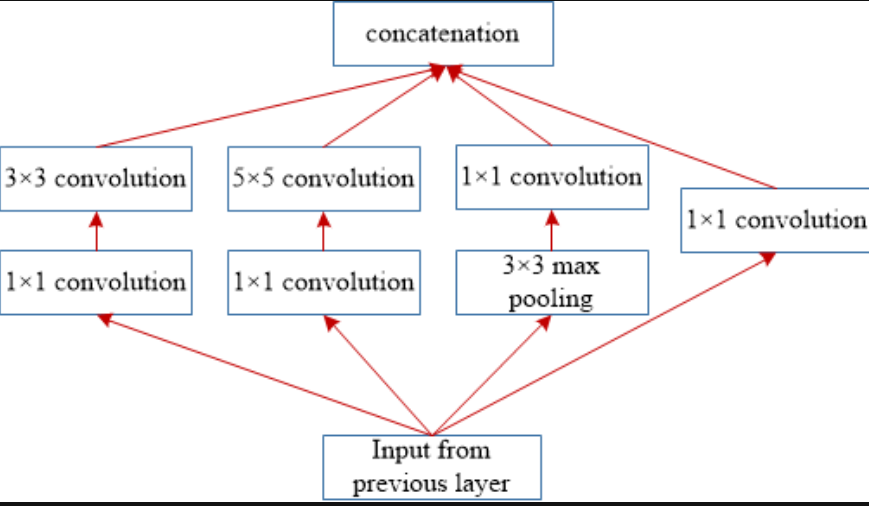

In [ ]:
import torch
import torch.nn as nn

class InceptionNet(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionNet, self).__init__()
        self.in_channels = 3


        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.relu1_1 = nn.ReLU(inplace=True)


        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.bn1_2 = nn.BatchNorm2d(64)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        #block1

        #1X1
        #for 3x3
        self.conv2_1 = nn.Conv2d(64, 32, kernel_size=1, padding='same')
        self.bn2_1 = nn.BatchNorm2d(32)
        self.relu2_1 = nn.ReLU(inplace=True)

        #for 5x5
        self.conv2_2 = nn.Conv2d(64, 8, kernel_size=1, padding='same')
        self.bn2_2 = nn.BatchNorm2d(8)
        self.relu2_2 = nn.ReLU(inplace=True)



        #maxpool
        self.pool2_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        #3x3
        self.conv2_4 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.bn2_4 = nn.BatchNorm2d(64)
        self.relu2_4 = nn.ReLU(inplace=True)

        #5x5
        self.conv2_5 = nn.Conv2d(8, 16, kernel_size=5, padding='same')
        self.bn2_5 = nn.BatchNorm2d(16)
        self.relu2_5 = nn.ReLU(inplace=True)

        #for 1x1
        self.conv2_3 = nn.Conv2d(64, 32, kernel_size=1, padding='same')
        self.bn2_3 = nn.BatchNorm2d(32)
        self.relu2_3 = nn.ReLU(inplace=True)

        #after maxpool
        self.conv2_6 = nn.Conv2d(64, 16, kernel_size=1, padding='same')
        self.bn2_6 = nn.BatchNorm2d(16)
        self.relu2_6 = nn.ReLU(inplace=True)


        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #block2

        #1X1
        #for 3x3
        self.conv3_1 = nn.Conv2d(128, 64, kernel_size=1, padding='same')
        self.bn3_1 = nn.BatchNorm2d(64)
        self.relu3_1 = nn.ReLU(inplace=True)

        #for 5x5
        self.conv3_2 = nn.Conv2d(128, 16, kernel_size=1, padding='same')
        self.bn3_2 = nn.BatchNorm2d(16)
        self.relu3_2 = nn.ReLU(inplace=True)

        #for 1x1
        self.conv3_3 = nn.Conv2d(128, 64, kernel_size=1, padding='same')
        self.bn3_3 = nn.BatchNorm2d(64)
        self.relu3_3 = nn.ReLU(inplace=True)

        #maxpool
        self.pool3_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        #3x3
        self.conv3_4 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.bn3_4 = nn.BatchNorm2d(128)
        self.relu3_4 = nn.ReLU(inplace=True)

        #5x5
        self.conv3_5 = nn.Conv2d(16, 32, kernel_size=5, padding='same')
        self.bn3_5 = nn.BatchNorm2d(32)
        self.relu3_5 = nn.ReLU(inplace=True)

        #after maxpool
        self.conv3_6 = nn.Conv2d(128, 32, kernel_size=1, padding='same')
        self.bn3_6 = nn.BatchNorm2d(32)
        self.relu3_6 = nn.ReLU(inplace=True)


        #final averagePool
        self.avg_pool = nn.AvgPool2d(kernel_size=8, stride=2)

        self.fc1 = nn.Linear(256, 2048)
        self.relu_fc1 = nn.ReLU(inplace=True)
        # self.fc2 = nn.Linear(4096, 4096)
        # self.relu_fc2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(2048, num_classes)


        self._initialize_weights()

    def forward(self, x):
      x = self.relu1_1(self.bn1_1(self.conv1_1(x)))
      x = self.relu1_2(self.bn1_2(self.conv1_2(x)))
      x = self.pool1(x)

      x_3x3 = self.relu2_1(self.bn2_1(self.conv2_1(x)))
      x_5x5 = self.relu2_2(self.bn2_2(self.conv2_2(x)))
      x_1x1 = self.relu2_3(self.bn2_3(self.conv2_3(x)))
      x_pool = self.pool2_1(x)

      x_3x3 = self.relu2_4(self.bn2_4(self.conv2_4(x_3x3)))
      x_5x5 = self.relu2_5(self.bn2_5(self.conv2_5(x_5x5)))
      x_pool = self.relu2_6(self.bn2_6(self.conv2_6(x_pool)))

      x = torch.cat([x_1x1, x_3x3, x_5x5, x_pool], dim=1)
      x = self.maxpool(x)

      x_3x3 = self.relu3_1(self.bn3_1(self.conv3_1(x)))
      x_5x5 = self.relu3_2(self.bn3_2(self.conv3_2(x)))
      x_1x1 = self.relu3_3(self.bn3_3(self.conv3_3(x)))
      x_pool = self.pool3_1(x)

      x_3x3 = self.relu3_4(self.bn3_4(self.conv3_4(x_3x3)))
      x_5x5 = self.relu3_5(self.bn3_5(self.conv3_5(x_5x5)))
      x_pool = self.relu3_6(self.bn3_6(self.conv3_6(x_pool)))

      x = torch.cat([x_1x1, x_3x3, x_5x5, x_pool], dim=1)
      x = self.avg_pool(x)

      x = x.view(x.size(0), -1)
      x = self.relu_fc1(self.fc1(x))
      x = self.fc3(x)

      return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [ ]:
num_classes = 10
num_epochs = 10
learning_rate = 0.075

model = InceptionNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[4,8],
                                               gamma=0.1)

total_step = len(train_loader)

In [ ]:
from google.colab import drive
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
drive.mount('/content/drive')

The training loop includes model checkpointing, which saves the model, optimizer, and scheduler states every two epochs to allow resuming training if interrupted. It also implements early stopping based on validation accuracy, halting training after three consecutive epochs of no improvement. Additionally, the loop ensures efficient memory management by clearing tensors and invoking garbage collection after each batch.

We only use 10 epoches considering resource constraints.

In [ ]:
import gc
import time

checkpoint_path = "/content/drive/MyDrive/inception.pth"


start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
total_step = len(train_loader)
best_val = -1
tolerance = 3
t = 0
loss_info = {'train':[], 'val':[]}
for epoch in range(start_epoch, num_epochs):
    t = time.time()
    for i, (images, labels) in enumerate(train_loader):
        # if total_step/2 == i+1:
        #   print("half way there")
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    scheduler.step()
    if (epoch + 1) % 2 == 0:
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state":scheduler.state_dict()
        }, os.path.join(os.path.dirname(checkpoint_path), f"inception_{epoch+1}.pth"))
        print(f"Checkpoint saved at epoch {epoch+1}")
    print ('epoch {}, Train loss: {:.4f}'.format(epoch+1, loss.item()))
    print("Time: {:.2f}".format( time.time()-t))
    loss_info['train'].append(loss.item())

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        loss_total = 0
        batch_size = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_size+=1

        loss_avg = loss_total/batch_size
        val_acc = 100 * correct / total
        print(f'Val acc: {val_acc:.2f}%    Val loss: {loss_avg: .2f}')
        loss_info['val'].append(loss_avg)


    if epoch > 0 and val_acc <= best_val:
        tolerance -= 1
        if tolerance == 0:
            print("early stopping")
            break
    else:
        best_val = val_acc
        tolerance = 3

epoch 1, Train loss: 1.4456
Time: 101.48
Val acc: 49.28%    Val loss:  1.37
Checkpoint saved at epoch 2
epoch 2, Train loss: 1.2158
Time: 101.38
Val acc: 64.38%    Val loss:  0.99
epoch 3, Train loss: 0.8362
Time: 101.23
Val acc: 67.14%    Val loss:  0.92
Checkpoint saved at epoch 4
epoch 4, Train loss: 0.8155
Time: 100.75
Val acc: 70.36%    Val loss:  0.84
epoch 5, Train loss: 0.6351
Time: 101.50
Val acc: 77.56%    Val loss:  0.65
Checkpoint saved at epoch 6
epoch 6, Train loss: 0.4026
Time: 102.15
Val acc: 77.58%    Val loss:  0.64
epoch 7, Train loss: 0.4786
Time: 102.14
Val acc: 79.20%    Val loss:  0.59
Checkpoint saved at epoch 8
epoch 8, Train loss: 0.6700
Time: 102.01
Val acc: 79.16%    Val loss:  0.60
epoch 9, Train loss: 0.4368
Time: 101.51
Val acc: 80.68%    Val loss:  0.56
Checkpoint saved at epoch 10
epoch 10, Train loss: 0.5343
Time: 101.58
Val acc: 80.44%    Val loss:  0.56


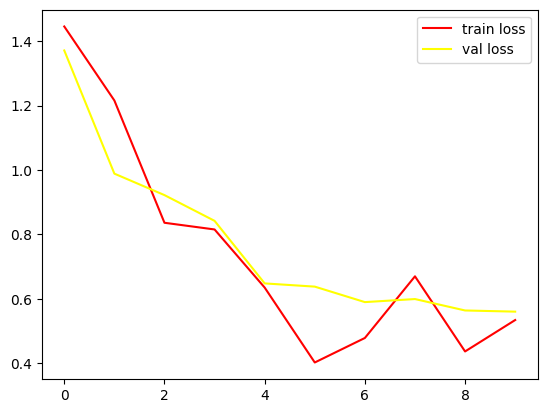

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_info['train'])), loss_info['train'], color='red', label='train loss')
plt.plot(range(len(loss_info['val'])), loss_info['val'], color='yellow', label='val loss')

plt.legend()

plt.show()

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.show()


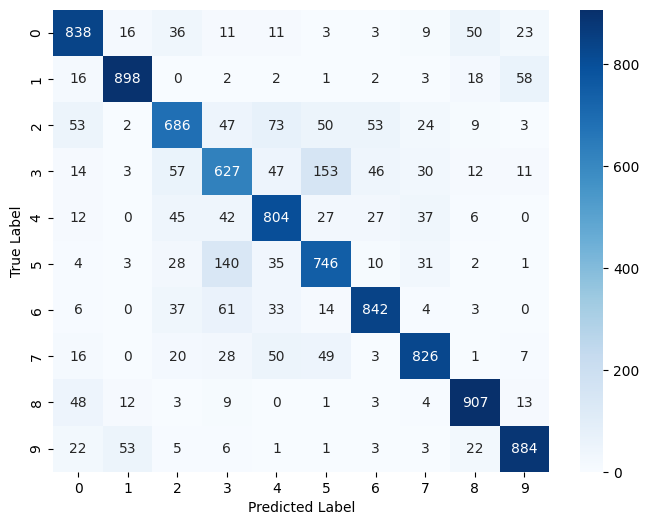

Accuracy 80.58%


In [ ]:
y_pred = []
y_true = []
model.eval()
checkpoint_path = "/content/drive/MyDrive/inception_10.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        model.to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

plot_confusion_matrix(y_true, y_pred, range(0,10))
print('Accuracy {}%'.format(100 * correct / total))